In [1]:
import logging
import sys
import os

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import json
import re
from collections import Counter
from math import exp

In [2]:
import networkx as nx
import xml.etree.ElementTree as ET

In [3]:
from collections import Counter, defaultdict
from math import exp

In [4]:
def enc (word):
    s = word.encode('utf-8')
    s = s.decode('utf-8')
    return s

In [5]:
class Word:
    def __init__(self, lemma, lang, s=[]):
        if lemma == None: self.lemma = ''
        else: self.lemma = enc(lemma)
        self.lang = lang
        self.s = s
        
    def __str__(self):
        if self.s:
            if isinstance(self.s[0],list):
                w = '['+'_'.join(['-'.join(i) for i in self.s])+']'
            else:
                w = '['+'-'.join(self.s)+']'
        else:
            w = '-'
        return str(self.lang)+'$'+str(self.lemma)+'$'+str(w)
    
    __repr__ = __str__
    
    def __eq__(self, other):
        return self.lemma == other.lemma and self.lang == other.lang and (self.s == other.s or other.s in self.s or self.s in other.s)
    
    def __lt__(self, other):
        if self.lang == other.lang:
            if self.lemma == other.lemma:
                s1 = set(self.s)
                s2 = set(other.s)
                if (not s1 - s2) and (s1&s2==s1) and (s2 - s1):
                    return True
                else:
                    return False
        else:
            return False
    
    def __hash__(self):
        return hash(str(self))
    
    def write(self, mode='mono'):
        if mode == 'mono':
            return self.lemma + '\t' + '$'.join([str(i) for i in self.s])
        elif mode == 'bi':
            return self.lang + '\t' +  self.lemma + '\t' + '$'.join([str(i) for i in self.s])

### Languages

In [6]:
def all_languages():
    G = nx.Graph()
    for root, dirs, files in os.walk ('./dictionaries/'):
        for fl in files :
            pair = fl.replace('.dix', '').split('-')
            G.add_edge(pair[0], pair[1])
    d = G.degree()
    d = sorted(d, key=d.get, reverse=True)
    #print (d)
    with open('languages','w',encoding='utf-8') as f:
        f.write('\t'.join(d))

In [6]:
%time all_languages()

Wall time: 5 ms


### Monodix

In [6]:
class Tags(list):
    def __le__(self, other):
        s1 = set(self)
        s2 = set(other)
        if not s1 - s2 and s1&s2==s1:
            return True
        else:
            return False
    
    def __lt__(self, other):
        s1 = set(self)
        s2 = set(other)
        if (not s1 - s2) and (s1&s2==s1) and (s2 - s1):
            return True
        else:
            return False
    
    def __eq__(self, other):
        if set(self) == set(other):
            return True
        else:
            return False
        
    def __str__(self):
        return '-'.join(self)
    
    __repr__ = __str__
    
    def __hash__(self):
        return hash(str(self))

In [7]:
class WordDict(dict):
    def lemma(self, lemma):
        self.lemma = lemma
        
class FilteredDict(dict):
    def set_lang(self, lang):
        self.lang = lang
    
    def lemma(self, lemma):
        return self[self.lang+'_'+lemma]
        
    def add(self, word):
        lemma = word.lang+'_'+word.lemma
        tags = Tags(word.s)
        if lemma in self:
            if tags in self[lemma]:
                self[lemma][tags] += 1
            else:
                self[lemma][tags] = 1
        else:
            self[lemma] = WordDict()
            self[lemma].lemma(lemma)
            self[lemma][tags] = 1

In [8]:
def one_language_dict(lang):
    dictionary = FilteredDict()
    dictionary.set_lang(lang)
    for root, dirs, files in os.walk ('./dictionaries/'):
        for fl in files :
            pair = fl.replace('.dix','').split('-')
            if lang in pair:
                if lang == pair[0]: side = 'l'
                else: side = 'r'
                try:
                    with open (root+fl, 'r', encoding='utf-8') as d:
                        t = ET.fromstring(d.read().replace('<b/>',' ').replace('<.?g>',''))     
                    for word in parse_one(t, side, lang):
                        dictionary.add(word)
                except:
                    pass
    return dictionary

In [57]:
dictionary = one_language_dict('afr')

In [73]:
dictionary['afr_almal']

{prn-tn-m: 1, prn-tn-mf: 2, det-ind: 1, prn: 1}

In [76]:
shorten(dictionary['afr_almal'])

('almal', [[prn-tn-mf, prn], [det-ind], [prn-tn-m]])

In [9]:
def shorten(word_dict):
    short = []
    for i in sorted(word_dict, key=lambda x: (word_dict[x], -len(x)), reverse=True):
        new = True
        for key, j in enumerate(short):
            inner = True
            for key2, k in enumerate(j):
                if (k < i) or (i < k): pass
                else: inner = False
            if inner: 
                short[key].append(i)
                new = False
        if new: short.append([i])
    word = word_dict.lemma[4:]
    return word, short

In [10]:
def one_word(word, lang):
    if word.text: st = str(word.text)
    else: st = ''
    s = [i.attrib['n'] for i in word.findall('.//s')]
    s = [i for i in s if i != '']
    return Word(st, lang, s)

def parse_one (tree, side, lang):
    tree = tree.find('section')
    for e in tree:
        p = e.find('p')
        if p:
            word = one_word(p.find(side), lang)
            yield word
        else:
            i = e.find('i')
            if i:
                word = one_word(i, lang)
                yield word
            else:
                pass

In [11]:
def dictionary_to_nodes(dictionary):
    for i in dictionary.keys():
        word, tags = shorten(dictionary[i])
        if '_' in word:
            word = word.replace('_', ' ')
        for tag in tags:
            yield Word(word, dictionary.lang, Tags([i for i in tag if i != '']))

In [12]:
def monodix():
    if not os.path.exists('./monodix/'):
        os.makedirs('./monodix/')
    with open('languages','r', encoding='utf-8') as f:
        langs = f.read().split('\t')
    for lang in langs:
        dictionary = one_language_dict(lang)
        with open ('./monodix/'+lang+'.dix', 'w', encoding = 'utf-16') as f:
            for i in dictionary_to_nodes(dictionary):
                f.write (i.write(mode='mono')+'\n')
        logging.info(lang)

In [14]:
%time monodix()

2018-06-07 18:11:53,831 | INFO : eng
2018-06-07 18:12:07,021 | INFO : spa
2018-06-07 18:12:14,277 | INFO : fin
2018-06-07 18:12:23,971 | INFO : epo
2018-06-07 18:12:30,287 | INFO : rus
2018-06-07 18:12:36,600 | INFO : ita
2018-06-07 18:12:43,339 | INFO : fra
2018-06-07 18:12:45,995 | INFO : pol
2018-06-07 18:12:55,739 | INFO : cat
2018-06-07 18:12:58,650 | INFO : kaz
2018-06-07 18:13:00,610 | INFO : tur
2018-06-07 18:13:01,691 | INFO : ces
2018-06-07 18:13:05,565 | INFO : deu
2018-06-07 18:13:07,619 | INFO : por
2018-06-07 18:13:14,566 | INFO : sme
2018-06-07 18:13:17,014 | INFO : hin
2018-06-07 18:13:19,833 | INFO : swe
2018-06-07 18:13:20,039 | INFO : ina
2018-06-07 18:13:21,746 | INFO : hbs
2018-06-07 18:13:23,014 | INFO : tat
2018-06-07 18:13:24,104 | INFO : eus
2018-06-07 18:13:25,432 | INFO : nld
2018-06-07 18:13:27,414 | INFO : slv
2018-06-07 18:13:29,441 | INFO : ron
2018-06-07 18:13:30,180 | INFO : bul
2018-06-07 18:13:36,721 | INFO : nor
2018-06-07 18:13:37,522 | INFO : isl
2

In [13]:
'n'.split('-')

['n']

In [8]:
class DiGetItem:
    def __init__(self):
        self.list = []
        self.dict = {}
    
    def add(self, word):
        if len (word.s) > 1:
            self.list.append(word)
        else:
            self.dict[word] = word
    
    def __getitem__(self, key):
        key2 = Word(key.lemma, key.lang, [''])
        if key in self.dict:
            return self.dict[key]
        else:
            if key2 in self.dict:
                return self.dict[key2]
            try:
                key = self.list[self.list.index(key)]
                return key
            except:
                print (key)

In [14]:
a = [[],[1]]
key = a[a.index([])]
key

[]

In [9]:
def import_mono(lang):
    dictionary = DiGetItem()
    with open ('./monodix/{}.dix'.format(lang), 'r', encoding='utf-16') as f:
        for line in f:
            string = line.strip('\n').split('\t')
            s = [Tags([j for j in i.split('-') if j !='']) for i in string[1].strip().split('$')]
            dictionary.add(Word(string[0], lang, s))
    return dictionary

In [42]:
epo = import_mono('ukr')

In [ ]:
for i in epo.dict:
    if i.s == [['adj']]:
        print(i)

In [16]:
if '':
    print ('1')

In [17]:
'' in Tags([])

False

In [ ]:
for i in epo.dict:
    if ['adj','sint'] in i.s:
        print (list(epo.dict[i].s))

In [16]:
def one_word(word, lang):
    s = word.findall('.//s')
    s = [i.attrib['n'] for i in s]
    if word.text: st = str(word.text)
    else: st = ''
    #s = Tags([i for i in s if i != ''])
    s = Tags(s)
    if '_' in st:
        st = st.replace('_',' ')
    return Word(st, lang, s)

def parse_bidix (tree, l1, l2):
    tree = tree.find('section')
    if not tree:
        pass
        #print (l1, l2)
    else:
        for e in tree:
            if 'r' in e.attrib:
                side = e.attrib['r']
                #print (side)
            else:
                side = ''
            p = e.find('p')
            if p:
                yield one_word(p.find('l'), l1), one_word(p.find('r'), l2), side
            else:
                i = e.find('i')
                if i:
                    yield one_word(i, l1), one_word(i, l2), side

In [23]:
str(None)

'None'

In [10]:
def check (word1, word2, lang1, lang2):
    #word1 = lang1[lang1.index(word1)]
    #word2 = lang2[lang2.index(word2)]
    word1 = lang1[word1]
    word2 = lang2[word2]
    return word1, word2

In [11]:
def existance(pair, nodes):
    if pair[0] in nodes and pair[1] in nodes:
        return True
    else:
        return False

def load_file(l1, l2):
    with open ('language_list.csv','r',encoding='utf-8') as f:
        languages = set([i.split('\t')[1].strip() for i in f.readlines()])
    with open ('{}-{}'.format(l1, l2), 'w', encoding='utf-16') as f:
        for root, dirs, files in os.walk ('./dictionaries/'):
            for fl in files:
                pair = fl.replace('.dix','').split('-')
                if existance(pair, languages):
                    logging.info('{}-{} started'.format(pair[0], pair[1]))
                    lang1 = import_mono(pair[0])
                    lang2 = import_mono(pair[1])
                    with open (root+fl, 'r', encoding='utf-8') as d:
                        try:
                            tree = ET.fromstring(d.read().replace('<b/>',' ').replace('<.?g>',''))
                            for word1, word2, side in parse_bidix (tree, pair[0], pair[1]):
                                try:
                                    word1, word2 = check (word1, word2, lang1, lang2)
                                    string = str(side) + '\t' + word1.write(mode='bi') + '\t' + word2.write(mode='bi') + '\n'
                                    f.write(string)
                                    #if side:
                                    #    print (string)
                                except:
                                    pass
                        except:
                            print ('ERROR: {}-{}'.format(pair[0], pair[1]))

In [19]:
s = 'eng$$-'
s = s.split('$')[-1]
s = [i for i in s.split('-') if i !='']
s

[]

In [37]:
'-'.join(['',''])

'-'

In [21]:
eng = import_mono('eng')

In [22]:
Word('general high school','eng',[''])

eng$general high school$[]

In [23]:
eng[Word('general high school','eng',[])]

eng$general high school$[]

In [25]:
afr = import_mono('afr')

In [26]:
afr[Word('self','afr',['prn'])]

afr$self$[prn_prn-ref]

In [50]:
key = Word('ryksgebied','afr',['n'])

In [51]:
key2 = Word(key.lemma, key.lang, [''])
if key in afr.dict:
    print ('return: ', afr.dict[key])
else:
    if key2 in afr.dict:
        print ('return: ', afr.dict[key2])
    try:
        key = afr.list[afr.list.index(key)]
        print ('return: ', key)
    except:
        print (key)

return:  afr$ryksgebied$[n]


In [80]:
%time load_file('rus', 'fra')

2018-06-01 23:09:18,466 | INFO : afr-nld started
....
2018-06-01 23:10:01,228 | INFO : bre-cym started
cym$ffôn$[n-]
...
2018-06-01 23:12:14,963 | INFO : ces-ces started
ces$abê$[cnjsub]
<--- CES ERRORS BECAUSE OF SAME left-right language --->ces$národnosť$[n-f]
ces$čislo$[n-nt]
...
2018-06-01 23:30:02,333 | INFO : epo-bul started
ERROR: epo-bul
...
2018-06-01 23:32:45,249 | INFO : epo-fas started
ERROR: epo-fas
...
2018-06-01 23:33:46,875 | INFO : epo-pol started
ERROR: epo-pol
...
2018-06-01 23:38:06,601 | INFO : fin-deu started
fin$asuin$[n-compound-only-L]
fin$uudelleen$[n-compound-only-L]
fin$uudelleen$[n-compound-only-L]
fin$lyhyt$[adj-pos-compound-only-L]
deu$Kurz$[atp-cmp-split]
2018-06-01 23:38:12,484 | INFO : fin-eng started
2018-06-01 23:39:37,890 | INFO : fin-fra started
ERROR: fin-fra
...
2018-06-02 00:01:07,068 | INFO : pol-lav started
ERROR: pol-lav
...
2018-06-02 00:03:14,444 | INFO : sah-eng started
ERROR: sah-eng
...
2018-06-02 00:16:50,957 | INFO : vie-eng started
Wa

In [ ]:
lang1.dict

In [ ]:
fl = './dictionaries/afr-nld.dix'
pair = ['afr','nld']
with open ('language_list.csv','r',encoding='utf-8') as f:
        languages = set([i.split('\t')[1].strip() for i in f.readlines()])
if existance(pair, languages):
    logging.info('{}-{} started'.format(pair[0], pair[1]))
    lang1 = import_mono(pair[0])
    lang2 = import_mono(pair[1])
    with open (fl, 'r', encoding='utf-8') as d:
        try:
            tree = ET.fromstring(d.read().replace('<b/>',' ').replace('<.?g>',''))
            for word1, word2, side in parse_bidix (tree, pair[0], pair[1]):
                try:
                    word1, word2 = check (word1, word2, lang1, lang2)
                    string = str(side) + '\t' + word1.write(mode='bi') + '\t' + word2.write(mode='bi') + '\n'
                    #f.write(string)
                except:
                    pass
        except:
            print ('ERROR: {}-{}'.format(pair[0], pair[1]))

## Reading from file

In [10]:
def change_encoding(file):
    with open(file, 'r', encoding='utf-16') as f:
        text = f.read()
    text = text.encode('utf-8')
    text = text.decode('utf-8')
    with open(file, 'w', encoding='utf-8') as f:
        f.write(text)

In [19]:
change_encoding('rus-fra')

In [11]:
def parse_line(line):
    side, lang1, lemma1, tags1, lang2, lemma2, tags2 = line.strip('\n').split('\t')
    tags1 = [Tags(i.split('-')) for i in tags1.split('$')]
    tags2 = [Tags(i.split('-')) for i in tags2.split('$')]
    return side, Word(lemma1, lang1, tags1), Word(lemma2, lang2, tags2)

In [12]:
def nodes_from_file(file):
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            yield parse_line(line)

# Loading graph

In [13]:
def built_from_file(file):
    G = nx.DiGraph()
    for side, word1, word2 in nodes_from_file(file):
        if not side:
            G.add_edge(word1, word2)
            G.add_edge(word2, word1)
        elif side == 'LR':
            G.add_edge(word1, word2)
        elif side == 'RL':
            G.add_edge(word2, word1)
        else:
            print (side)
    return G

## Search (changed)

In [14]:
class SetWithFilter(set):
    def lemma(self, value):
        return set(i for i in self if i.lemma == value)
    def lang(self, value):
        return set(i for i in self if i.lang == value)

In [15]:
def dictionaries(lang1,lang2):
    l1 = import_mono(lang1)
    l2 = import_mono(lang2)
    l1 = SetWithFilter(l1.list+list(l1.dict.keys()))
    l2 = SetWithFilter(l2.list+list(l2.dict.keys()))
    return l1, l2

In [15]:
def lemma_search (G, lemma, d_l1, l2, cutoff):
    lemmas = d_l1.lemma(lemma)
    results = {str(word):{} for word in lemmas}
    for word in lemmas:
        print(word, end='\t')
        s = SetWithFilter(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
        print ('all: ', str(len(s)), end='\t')
        s = s.lang(l2)
        print ('filtered: ', str(len(s)))
        for translation in s:
            t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
            t = [len(i) for i in t]
            t = Counter(t)
            coef = 0
            for i in t:
                coef += exp(-t[i])
            results[str(word)][str(translation)] = coef
    return results

In [16]:
def print_results(results, n=7):
    for i in results:
        print ('\n\t\t', i)
        for j in sorted(results[i], key=results[i].get, reverse=True)[:n]:
            print (j, results[i][j])

In [172]:
%time l1, l2 = dictionaries('rus', 'fra')

Wall time: 1.8 s


In [189]:
%time print_results(lemma_search (G, 'кот', l1, 'fra', 6))

rus$кот$[n-m-aa]	all:  53	filtered:  8

		 rus$кот$[n-m-aa]
fra$chat$[n-GD] 1.2389736067509398
fra$chat$[n-f] 1.2389736067509398
fra$chat mâle$[n-m] 0.36787944117144233
fra$matou$[n-m] 0.36787944117144233
fra$chat$[n-m_n_n-m-ND] 0.17196656101408103
fra$salon$[n-m_n_n-m-ND_n-m-sg] 0.01865110151663669
fra$bavardage$[n-m_n_n-m-ND] 0.018321783101087508
Wall time: 72.9 ms


## Full RUS-FRA (on many languages)

In [17]:
def get_relevant_languages(l1, l2):
    G = nx.Graph()
    for root, dirs, files in os.walk ('./dictionaries/'):
        for fl in files :
            pair = fl.replace('.dix', '').split('-')
            G.add_edge(pair[0], pair[1])
    pair = [l1, l2]
    
    with open('languages','r', encoding='utf-8') as f:
        languages = f.read().split('\t')
        
    with open('language_list.csv','w', encoding='utf-8') as f:
        nodes = set()
        for i in range(1,5):
            w = nx.single_source_shortest_path_length(G, pair[0], cutoff=i)
            v = nx.single_source_shortest_path_length(G, pair[1], cutoff=i)
            H = G.subgraph(w.keys()).copy()
            H.remove_node(pair[0])
            H2 = G.subgraph(v.keys()).copy()
            H2.remove_node(pair[1])
            if pair[1] in H.nodes():
                v = nx.node_connected_component(H, pair[1])
            else:
                v = set()
            if pair[0] in H2.nodes():
                w = nx.node_connected_component(H, pair[1])
            else:
                w = set() 
            nodes2 = v & w | set([pair[0], pair[1]])
            nodes2 = nodes2 - nodes
            #for node in nodes2:
            #    f.write('{}\t{}\n'.format(i*2, node))
            for lang in languages:
                if lang in nodes2:
                    f.write('{}\t{}\n'.format(i*2, lang))
            nodes = nodes | nodes2

In [202]:
get_relevant_languages('rus', 'fra')

In [29]:
def lemma_search (G, lemma, d_l1, l2, cutoff):
    lemmas = d_l1.lemma(lemma)
    results = {str(word):{} for word in lemmas}
    for word in lemmas:
        print(word, end='\t')
        #%time SetWithFilter(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
        s = SetWithFilter(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
        print ('all: ', str(len(s)), end='\t')
        #%time s.lang(l2)
        s = s.lang(l2)
        print ('filtered: ', str(len(s)))
        for translation in s:
            #%time t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
            t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
            t = [len(i) for i in t]
            t = Counter(t)
            coef = 0
            for i in t:
                coef += exp(-t[i])
            results[str(word)][str(translation)] = coef
    return results

In [17]:
#from itertools import islice
#def k_shortest_paths(G, source, target, k, weight=None):
#    return list(islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))

class FilteredList(list):
    def lemma(self, value):
        return list(i for i in self if i.lemma == value)
    def lang(self, value):
        return list(i for i in self if i.lang == value)

def lemma_search2 (G, lemma, d_l1, l2, cutoff):
    lemmas = d_l1.lemma(lemma)
    results = {str(word):{} for word in lemmas}
    for word in lemmas:
        print(word, end='\t')
        #%time SetWithFilter(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
        s = FilteredList(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
        print ('all: ', str(len(s)), end='\t')
        #%time s.lang(l2)
        s = s.lang(l2)[:20]
        print ('filtered: ', str(len(s)))
        for translation in s:
            #%time t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
            t = nx.all_simple_paths(G, word, translation, cutoff=cutoff)
            t = [len(i) for i in t]
            t = Counter(t)
            coef = 0
            for i in t:
                coef += exp(-t[i])
            results[str(word)][str(translation)] = coef
    return results

** Loading file **

In [21]:
%time G = built_from_file('rus-fra')

Wall time: 4min 15s


In [22]:
print (len(G.nodes()), len(G.edges()))

1861933 4164055


In [30]:
for i in G.nodes():
    if i.lemma == 'книга':
        print (i)

rus$книга$[n-f-nn_n_n-f]
bul$книга$[n-f]
mkd$книга$[n-f_n]
kpv$книга$[n]
ukr$книга$[n-f_n-f-nn]
udm$книга$[n]


In [25]:
%time l1, l2 = dictionaries('rus', 'fra')

Wall time: 2.35 s


In [94]:
%time print_results(lemma_search (G, 'собака', l1, 'fra', 4), 10)

rus$собака$[n-f-aa_n_n-f]	all:  3327	filtered:  20

		 rus$собака$[n-f-aa_n_n-f]
fra$arobace$[n-f] 0.7357588823428847
fra$escargot$[n-m_n] 0.42440445653839176
fra$étau$[n-m_n] 0.4176665095393063
fra$chien$[n-GD] 0.374617429569905
fra$limaçon$[n-m] 0.3746173881705278
fra$singe$[n-m_n] 0.3746173881705278
fra$but$[n-m_n_n-m-ND] 0.3703581933481087
fra$arobase$[n-f] 0.36787944117144233
fra$loge$[n-f_n] 0.36787944117144233
fra$goal$[n_n-m] 0.36787944117144233
Wall time: 649 ms


In [100]:
word = 'город'
%time print_results(lemma_search (G, word, l1, 'fra', 4), 10)
%time print_results(lemma_search2 (G, word, l1, 'fra', 4), 10)

rus$город$[n-m-nn_n-m_n]	all:  4173	filtered:  49

		 rus$город$[n-m-nn_n-m_n]
fra$municipalité$[n_n-f] 0.3861950800601765
fra$mégalopole$[n-f] 0.36821490379934485
fra$commune$[n-f_n-f-ND] 0.36800285097552904
fra$commander$[vblex] 0.36787944117144233
fra$implantation$[n-f_n] 0.36787944117144233
fra$province$[n_n-f_n-f-ND] 0.36787944117144233
fra$convier$[vblex] 0.36787944117144233
fra$château$[n_n-m_n-m-ND] 0.36787944117144233
fra$demander$[vblex] 0.36787944117144233
fra$centre$[n-m_n_n-m-ND] 0.36787944117144233
Wall time: 1.92 s
rus$город$[n-m-nn_n-m_n]	all:  4173	filtered:  20

		 rus$город$[n-m-nn_n-m_n]
fra$municipalité$[n_n-f] 0.3861950800601765
fra$mégalopole$[n-f] 0.36821490379934485
fra$commune$[n-f_n-f-ND] 0.36800285097552904
fra$conseil municipal$[n-m_n] 0.36787944117144233
fra$cité$[n_n-f_n-f-ND] 0.13533532463598988
fra$ville$[n-f_n_n-f-ND] 0.1353352835155595
fra$poste$[n-m_n-m-ND_n] 0.1353352832366127
fra$capital$[n-m_n_n-m-ND] 0.1353352832366127
fra$bourgade$[n_n-f_n-f-ND]

In [133]:
word = 'кошка'
%time print_results(lemma_search (G, word, l1, 'fra', 4), 10)
%time print_results(lemma_search2 (G, word, l1, 'fra', 4), 10)

rus$кошка$[n-f-aa]	all:  1564	filtered:  16

		 rus$кошка$[n-f-aa]
fra$chat$[n-GD] 0.3863184898642632
fra$chat$[n-f] 0.3861973403895835
fra$jeunesse$[n-f_n_n-f-ND] 0.36787944117144233
fra$fête$[n-f_n_n-f-ND] 0.36787944117144233
fra$parti$[n_n-m_n-m-ND] 0.36787944117144233
fra$match$[n_n-m_n-m-ND] 0.36787944117144233
fra$chaton$[n-m] 0.36787944117144233
fra$chien$[n-GD] 0.36787944117144233
fra$chien$[n_n-m_n-m-ND] 0.36787944117144233
fra$gaillard$[n_n-m_n-m-ND] 0.1353352832366127
Wall time: 314 ms
rus$кошка$[n-f-aa]	all:  1564	filtered:  16

		 rus$кошка$[n-f-aa]
fra$chat$[n-GD] 0.3863184898642632
fra$chat$[n-f] 0.3861973403895835
fra$chaton$[n-m] 0.36787944117144233
fra$fête$[n-f_n_n-f-ND] 0.36787944117144233
fra$match$[n_n-m_n-m-ND] 0.36787944117144233
fra$parti$[n_n-m_n-m-ND] 0.36787944117144233
fra$chien$[n-GD] 0.36787944117144233
fra$chien$[n_n-m_n-m-ND] 0.36787944117144233
fra$jeunesse$[n-f_n_n-f-ND] 0.36787944117144233
fra$partenaire$[n-mf_n_n-mf-ND] 0.1353352832366127
Wall time:

In [31]:
def translations(G, word, cutoff):
    s = None
    if word not in G.nodes():
        return None
    s = FilteredList(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
    if len(s) > 100:
        print ('all: ', str(len(s)), end='\t')
        s = s.lang(l2)
        print ('filtered: ', str(len(s)))
        if len(s) > 10:
            s = s[:20]
    else:
        print ('all: ', str(len(s)), end='\t')
        s = s.lang(l2)
        print ('filtered: ', str(len(s)))
        k = 1
        if len(s) > 10:
            s = s[:20]
        else:
            while k < 8:
                s = FilteredList(nx.single_source_shortest_path_length(G, word, cutoff=cutoff+k))
                print ('all: ', str(len(s)), end='\t')
                s = s.lang(l2)
                print ('filtered: ', str(len(s)))
                if len(s) > 5:
                    s = s[:20]
                    break
                else:
                    k += 1
    return s

In [18]:
def lemma_search3 (G, lemma, d_l1, l2, cutoff):
    lemmas = d_l1.lemma(lemma)
    results = {str(word):{} for word in lemmas}
    k = 0
    for word in lemmas:
        print(word)
        if word not in G.nodes():
            break
        s = FilteredList(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
        if len(s) > 100:
            print ('all: ', str(len(s)), end='\t')
            s = s.lang(l2)
            print ('filtered: ', str(len(s)))
            if len(s) > 10:
                s = s[:20]
        else:
            print ('all: ', str(len(s)), end='\t')
            s = s.lang(l2)
            print ('filtered: ', str(len(s)))
            k = 1
            if len(s) > 10:
                s = s[:20]
            else:
                while k < 8:
                    s = FilteredList(nx.single_source_shortest_path_length(G, word, cutoff=cutoff+k))
                    print ('all: ', str(len(s)), end='\t')
                    s = s.lang(l2)
                    print ('filtered: ', str(len(s)))
                    if len(s) > 5:
                        s = s[:20]
                        break
                    else:
                        k += 1
        for translation in s:
            #%time t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
            t = nx.all_simple_paths(G, word, translation, cutoff=cutoff+k)
            t = [len(i) for i in t]
            t = Counter(t)
            coef = 0
            for i in t:
                coef += exp(-t[i])
            results[str(word)][str(translation)] = coef
    return results

In [190]:
word = 'простокваша'
%time print_results(lemma_search3 (G, word, l1, 'fra', 4), 10)

rus$простокваша$[n-f-nn]
all:  14	filtered:  1
all:  16	filtered:  1
all:  20	filtered:  1
all:  24	filtered:  1
all:  77	filtered:  2
all:  148	filtered:  2
all:  1109	filtered:  22

		 rus$простокваша$[n-f-nn]
fra$kéfir$[n_n-m_n-m-sg] 1.00642944881611
fra$lait$[n-m_n_n-m-ND] 0.1353353957717874
fra$chaussure$[n-f_n_n-f-ND] 0.1353352832366127
fra$soulier$[n-m_n] 0.1353352832366127
fra$gorgée$[n-f_n-f-ND] 0.1353352832366127
fra$lion$[n-GD] 0.1353352832366127
fra$lion$[n_n-m_n-m-ND] 0.1353352832366127
fra$soupape$[n_n-f] 0.1353352832366127
fra$valve$[n_n-f] 0.1353352832366127
fra$ton$[n_n-m_n-m-ND] 0.1353352832366127
Wall time: 629 ms


In [191]:
word = 'ряженка'
%time print_results(lemma_search3 (G, word, l1, 'fra', 4), 10)

rus$ряженка$[n-f-nn]
all:  2	filtered:  0
all:  2	filtered:  0
all:  2	filtered:  0
all:  2	filtered:  0
all:  2	filtered:  0
all:  2	filtered:  0
all:  2	filtered:  0
all:  2	filtered:  0

		 rus$ряженка$[n-f-nn]
Wall time: 46 ms


In [192]:
word = 'просо'
%time print_results(lemma_search3 (G, word, l1, 'fra', 4), 10)

rus$просо$[n-nt-nn_n]
all:  50	filtered:  2
all:  131	filtered:  4
all:  246	filtered:  6

		 rus$просо$[n-nt-nn_n]
fra$millet$[n-m] 0.8781675752064854
fra$panique$[n_n-f] 0.3746173881705278
fra$étape$[n_n-f_n-f-ND] 0.1353352832366127
fra$mille$[n-m] 0.01831563916768099
fra$mile$[n-m] 0.01831563888873418
fra$panique$[n-m_n-m-ND] 0.006740207328492448
Wall time: 354 ms


In [193]:
word = 'гречка'
%time print_results(lemma_search3 (G, word, l1, 'fra', 4), 10)

rus$гречка$[n-f-nn]
all:  36	filtered:  3
all:  39	filtered:  3
all:  41	filtered:  4
all:  48	filtered:  4
all:  85	filtered:  6

		 rus$гречка$[n-f-nn]
fra$blé sarrasin$[n-m] 0.7947626498865004
fra$blé noir$[n-m] 0.7947626498865004
fra$froment$[n_n-m_n-m-ND] 0.7424968293419701
fra$maïs$[n-m] 0.36787944117144233
fra$sarrasin$[n-m] 0.33968515569537805
fra$blé$[n_n-m_n-m-ND] 0.0009118819655545162
Wall time: 1.12 s


In [204]:
word = 'страна'
%time print_results(lemma_search3 (G, word, l1, 'fra', 4), 10)

rus$страна$[n-f-nn_n-f_n]
all:  8266	filtered:  115
rus$страна$[np-top-f]

		 rus$страна$[n-f-nn_n-f_n]
fra$latéral$[n-f] 0.7357588823428847
fra$latéral$[n-m] 0.503214724408055
fra$habitant$[n-f] 0.3861950800601765
fra$campagne$[n-f_n_n-f-ND] 0.3703581933481087
fra$localité$[n-f_n_n-f-ND] 0.3703581933481087
fra$page$[n-f_n_n-f-ND] 0.36879132313699686
fra$bourgade$[n_n-f_n-f-ND] 0.36879132313699686
fra$côté$[n-m_n_n-m-ND] 0.36821490379934485
fra$masse$[n_n-f_n-f-ND] 0.36821490379934485
fra$habitant$[n-m_n_n-m-pl] 0.3679248411012048

		 rus$страна$[np-top-f]
Wall time: 1.87 s


In [206]:
word = 'очень'
%time print_results(lemma_search3 (G, word, l1, 'fra', 4), 10)

rus$очень$[n]
all:  43	filtered:  3
all:  231	filtered:  7
rus$очень$[adv]
all:  2399	filtered:  72

		 rus$очень$[n]
fra$solde$[n_n-m_n-m-pl] 0.4176665095393063
fra$solide indéformable$[n-m] 0.36787944117144233
fra$solide$[n-m] 0.36787944117144233
fra$solde$[n-m-sg] 0.36787944117144233
fra$bilan$[n_n-m_n-m-ND] 0.36787944117144233
fra$équilibre$[n-m_n_n-m-ND] 0.36787944117144233
fra$solidité$[n_n-f] 0.36787944117144233

		 rus$очень$[adv]
fra$fort$[adv] 0.553001792775919
fra$durement$[adv] 0.387106962025731
fra$quand même$[adv] 0.38619508006205605
fra$aussi$[adv] 0.36879132313699686
fra$dessus$[adv] 0.36821490379934485
fra$très$[adv] 0.36821490379934485
fra$fortement$[adv] 0.36821490379934485
fra$plus$[adv] 0.36800285097552904
fra$en plus$[adv] 0.36800285097552904
fra$hautement$[adv] 0.36800285097552904
Wall time: 3.32 s


In [208]:
word = 'тип'
%time print_results(lemma_search3 (G, word, l1, 'fra', 4), 10)

rus$тип$[n-m-nn]
all:  2829	filtered:  48
rus$тип$[n-m-aa_n]
all:  8642	filtered:  186

		 rus$тип$[n-m-nn]
fra$tarif$[n-m_n-m-ND] 0.4176665095393063
fra$taxe$[n-f_n_n-f-ND] 0.3861950800601765
fra$formulaire$[n-m_n_n-m-ND] 0.3746173881705278
fra$indice$[n_n-m_n-m-ND] 0.3746173881705278
fra$rythme$[n-m_n_n-m-ND] 0.3746173881705278
fra$taux$[n-m-sp_n-m_n] 0.3746173881705278
fra$index$[n-m-sp_n-m_n] 0.3746173881705278
fra$style$[n_n-m_n-m-ND] 0.36879132313699686
fra$aspect$[n-m_n_n-m-ND] 0.36800285097552904
fra$forme$[n-f_n_n-f-ND] 0.3679248411012048

		 rus$тип$[n-m-aa_n]
fra$phylum$[n-m] 0.8710941655794974
fra$mec$[n_n-m_n-m-ND] 0.7424968293419701
fra$espèce$[n-f_n_n-f-ND] 0.5032147244081486
fra$zèbre$[n-f] 0.4176665095393063
fra$nature$[n-f_n_n-f-ND] 0.3746173881705278
fra$fil$[n-m_n_n-m-ND] 0.3703581933481087
fra$personne$[n_n-f_n-f-ND] 0.3703581933481087
fra$caractère$[n_n-m_n-m-ND] 0.36821490379934485
fra$modèle$[n_n-m_n-m-ND] 0.3678855853837957
fra$sorte$[n-f_n-f-ND_n] 0.1353414274

## Evaluation

In [34]:
get_relevant_languages('spa', 'eng')

In [33]:
%time load_file('spa', 'eng')

2018-06-08 16:50:12,426 | INFO : cat-ita started
2018-06-08 16:50:55,954 | INFO : eng-cat started
2018-06-08 16:56:36,317 | INFO : eng-deu started
2018-06-08 16:58:00,452 | INFO : eng-ita started
2018-06-08 16:59:35,272 | INFO : eng-pol started
2018-06-08 16:59:45,574 | INFO : eng-spa started
2018-06-08 17:02:12,603 | INFO : epo-cat started
2018-06-08 17:04:02,248 | INFO : epo-ces started
2018-06-08 17:04:04,297 | INFO : epo-deu started
2018-06-08 17:04:08,281 | INFO : epo-eng started
2018-06-08 17:04:35,520 | INFO : epo-fin started
2018-06-08 17:04:38,236 | INFO : epo-fra started
2018-06-08 17:05:10,196 | INFO : epo-ita started
2018-06-08 17:05:13,698 | INFO : epo-spa started
2018-06-08 17:07:47,775 | INFO : fin-ces started
2018-06-08 17:07:48,974 | INFO : fin-deu started
fin$asuin$[n-compound-only-L]
fin$uudelleen$[n-compound-only-L]
fin$uudelleen$[n-compound-only-L]
fin$lyhyt$[adj-pos-compound-only-L]
deu$Kurz$[atp-cmp-split]
2018-06-08 17:07:54,014 | INFO : fin-eng started
2018-06-

In [34]:
change_encoding('spa-eng')

In [19]:
def node_search(node, l2, cutoff):
    if node not in G.nodes():
        return None
    s = FilteredList(nx.single_source_shortest_path_length(G, node, cutoff=cutoff))
    results = {}
    k = 0
    if len(s) > 100:
        s = s.lang(l2)
        if len(s) > 5 :s = s[:20]
    else:
        while k < 8:
            s = FilteredList(nx.single_source_shortest_path_length(G, node, cutoff=cutoff+k))
            s = s.lang(l2)
            if len(s) > 5:
                s = s[:20]
                break
            else: k += 1#translations(G, word, cutoff)
        for translation in s:
            t = Counter([len(i) for i in nx.all_simple_paths(G, node, translation, cutoff=cutoff+k)])
            coef = 0
            for i in t: coef += exp(-t[i])
            results[translation] = coef
    return list(sorted(results, key=results.get, reverse=True))

In [28]:
results = {'abba': 10, 'a':1, 'q':90}
list(sorted(results, key=results.get, reverse=True))

['q', 'abba', 'a']

In [54]:
def two_node_search (G, node1, node2, l1, l2, cutoff):
    if (node1, node2) in G.edges(): G.remove_edge(node1, node2)
    if (node2, node1) in G.edges(): G.remove_edge(node2, node1)
    res1 = node_search(node1, l2, cutoff)
    res2 = node_search(node2, l1, cutoff)
    coefficient = 0
    if node2 in res1: coefficient += 0.5*(len(res1) - res1.index(node2))/len(res1)
    if node1 in res2: coefficient += 0.5*(len(res2) - res2.index(node1))/len(res2) 
    #if not res1: res1 = ['-']  
    #if not res2: res2 = ['-']    
    #print (node1.lemma, node2.lemma, coefficient, res1[0], res2[0]) 
    #print ('\t', res1)
    #print ('\t', res2)
    #coefficient = coefficient/(n/2)
    return coefficient

In [38]:
del G

In [20]:
%time G = built_from_file('spa-eng')

R:
EL
Wall time: 1min 13s


In [24]:
%time l1, l2 = dictionaries('spa', 'eng')

Wall time: 5.92 s


In [22]:
print (len(G.edges()), len(G.nodes()))

1422343 742596


In [29]:
import random
candidates = random.sample(l1, 10000)
pairs = []
for i in candidates:
    if i in G.nodes():
        s = FilteredList(list(G.neighbors(i))).lang('eng')
        #if (i.lemma.capitalize() != i.lemma) and (G.degree(i) > 4) and (not ' ' in i.lemma):
        if len(s) == 1:
            n = G.number_of_edges(s[0], i) + G.number_of_edges(i, s[0])
            pairs.append((i, s[0], n))
len(pairs)

2278

In [39]:
pairs2 = pairs[:1000]

In [41]:
pairs2[:10]

[(spa$anatema$[n-f_n], eng$anathema$[n], 2),
 (spa$escalafón$[n_n-m], eng$echelon$[n], 2),
 (spa$hablante$[n-mf_n_n-mf-sg], eng$speaker$[n_n-ND], 2),
 (spa$Guinevere$[np-ant], eng$Guinevere$[np-ant_np-ant-f-sg], 2),
 (spa$aplicar$[vblex], eng$apply$[vblex], 2),
 (spa$Berlanga$[np_np-cog_np-cog-mf], eng$Berlanga$[_np-cog_np-cog-sg], 2),
 (spa$laparotomía$[n_n-f], eng$laparotomy$[n], 2),
 (spa$Erik$[np_np-ant], eng$Erik$[np-ant-m-sg_np-ant_np-ant-m_np], 2),
 (spa$Ambre$[np-ant], eng$Ambre$[np-ant_np-ant-f-sg], 2),
 (spa$Euskaltel$[np_np-al-m-sg], eng$Euskaltel$[np-al-sg], 2)]

In [28]:
len(pairs2)

1000

In [51]:
def evaluate(G, pairs, l1, l2, cutoff):
    result = []
    for i in pairs:
        result.append(two_node_search (G, i[0], i[1], l1, l2, cutoff))
    return result

In [55]:
%time result = evaluate(G, pairs2, 'spa', 'eng', 4)

Wall time: 56.6 s


In [49]:
import matplotlib.pyplot as plt

In [56]:
sum(result)/10

40.412318318291646

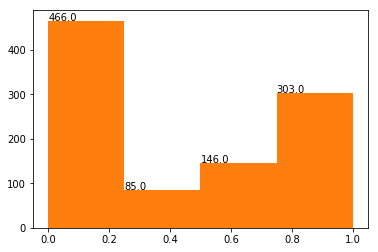

In [76]:
bins = 4
plt.hist(result, bins=bins)
arr=plt.hist(result,bins=bins)
for i in range(bins):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.show()

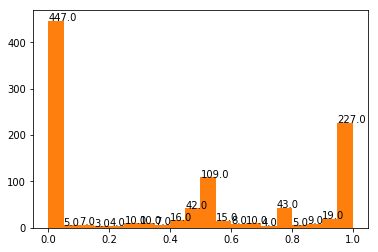

In [77]:
bins = 20
plt.hist(result, bins=bins)
arr=plt.hist(result,bins=bins)
for i in range(bins):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.show()

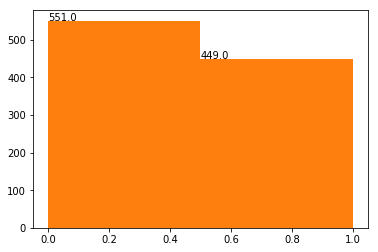

In [81]:
bins = 2
plt.hist(result, bins=bins)
arr=plt.hist(result,bins=bins)
for i in range(bins):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.show()